<font size="5.5"><u><i>Build Strain Dataset</i></u></font>

<font size="4">Script to build a dataset with multiple waveforms injections</font>
<br/>
<font size="4">Author: Manuel David Morales</font>

## 1. Library imports

In [1]:
# Data analysis
import numpy as np 
import pandas as pd
import math

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Files/folders management
import os, glob, sys, re

# To read csv files
import csv

# Scientific computing
from scipy import signal

# Garbage collector
import gc

# Object serialization
import pickle

# Toolbox functions
from Toolbox import PSD, SNR, WaveletTF_transform

## 2. Input parameters

In [2]:
# Interferometer for noise data
# ------------------------------------------------------------
detector = "H1"    # Options: "L1", "H1", "V1"
# ------------------------------------------------------------

# ------> Input parameters for window samples generation

# Jitter_lim: This value defines a fluctuation range, in which each
# injection will be located on a random sample in the interval
# [inj_time - jitter_lim, inj_time + jitter_lim] (in seconds)

# -------------------------------------------------------------------------------------
jitter_lim = 0.01   # Ensure this value is the same as in Make_Injections script
# -------------------------------------------------------------------------------------

# Scalar parameter in window time for samples (in seconds)

# ------------------------------------------------------------
alpha = 0.02001    # alpha must be greater than 2*jitter_lim
# ------------------------------------------------------------

# Plot windows samples (time & TF domain)

# ------------------------------------------------------------
set_doplots = 1    #  1: yes | 0: no
# ------------------------------------------------------------

In [3]:
# ------> Check

if alpha <= 2*jitter_lim:
    print("")
    print("******** Error: alpha must be greater than 2*jitter_lim ********")
    print("")
    
    raise SystemExit("Code stopped here!")
    
else:
    pass

# Remark: The condition alpha > 2*jitter_lim ensures that
#         the whole injected waveform will be in the window sample.

## 3. Read files

In [4]:
# ------> Specify folder location

rawdata_dir = '/home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Codes/Preprocessed_Data'

# ------> Initialize lists

time = []
strain = []
inj_time = []
jitt = []
SNR_waveform = []
gmode_slope = []
f0 = []
f1 = []
duration_wf = []

s_files = []
l_files = []

# ------> Scan strain data and log data files

os.chdir(rawdata_dir)

for file in glob.glob("strain_" + detector + "*cond*"):
    s_files.append(file)
    
for file in glob.glob("log_" + detector + "*"):
    l_files.append(file)

In [5]:
print("Available log data files")
for file in range(len(l_files)):
    print(l_files[file] + "  |  Input option :", file)
print("")

file_i = input("======> Enter your option:")
file_i = int(file_i)
print("")

# ------> Load log file with information about injections

print("***** READING LOG DATA FILE", l_files[file_i], " *****")
with open(l_files[file_i]) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Data columns: {", ".join(row)}')
            line_count += 1
        else:
            inj_time.append(row[0])
            jitt.append(row[1])
            SNR_waveform.append(row[2])
            gmode_slope.append(row[3])
            f0.append(row[4])
            f1.append(row[5])
            duration_wf.append(row[6])
            #print(f'\t{row[0]} works in the {row[1]}.')
            line_count += 1
    print(f'Processed {line_count} lines')

Available log data files
log_H1_1257050112_wfclass2.dat  |  Input option : 0



======> Enter your option: 0



***** READING LOG DATA FILE log_H1_1257050112_wfclass2.dat  *****
Data columns: Injection time [s], jitter (seconds), Waveform SNR, G-mode slope, Frequency f0 [Hz], Frequency f1 [Hz], Waveform duration [s]
Processed 15 lines


In [6]:
print("Available conditioned strain data files")
for file in range(len(s_files)):
    print(s_files[file] + "  |  Input option :", file)
print("")

file_i = input("======> Enter your option:")
file_i = int(file_i)
print("")

# ------> Load strain data (this data include injections) 

print("***** READING FILE", s_files[file_i], " *****")
with open(s_files[file_i]) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Data columns: {", ".join(row)}')
            line_count += 1
        else:
            time.append(row[0])
            strain.append(row[1])
            #print(f'\t{row[0]} works in the {row[1]}.')
            line_count += 1
    print(f'Processed {line_count} lines')

Available conditioned strain data files
strain_H1_1257050112_conditioned_wfclass2.txt  |  Input option : 0



======> Enter your option: 0



***** READING FILE strain_H1_1257050112_conditioned_wfclass2.txt  *****
Data columns: time, strain
Processed 450561 lines


In [7]:
# ------> Convert lists to numpy arrays, clear memory from lists

t = np.array(time, dtype='float64')
del(time)
gc.collect()

s = np.array(strain, dtype='float64')
del(strain)
gc.collect()

t_inj = np.array(inj_time, dtype='float64')
del(inj_time)
gc.collect()

jitter = np.array(jitt, dtype='float64')
del(jitt)
gc.collect()

wf_SNR = np.array(SNR_waveform, dtype='float64')
del(SNR_waveform)
gc.collect()

Slope = np.array(gmode_slope, dtype='float64')
del(gmode_slope)
gc.collect()

f_ini = np.array(f0, dtype='float64')
del(f0)
gc.collect()

f_end = np.array(f1, dtype='float64')
del(f1)
gc.collect()

wf_duration = np.array(duration_wf, dtype='float64')
del(duration_wf)
gc.collect()

0

In [8]:
# ------> Check array dimensions

print("Time array length:", len(t))
print("Strain array length:", len(s))
print("")
print("Injection times array length:", len(t_inj))
print("WF SNR array length:", len(wf_SNR))
print("WF durations array length:", len(wf_duration))

Time array length: 450560
Strain array length: 450560

Injection times array length: 14
WF SNR array length: 14
WF durations array length: 14


## 4. Window samples preparation

In [9]:
# ------> Compute maximum waveform duration (in seconds)
# Remark: For this calculation, we consider all waveforms saved on Waveforms folder

waveforms_dir = "/home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Waveforms_mod/Phen/"

# Load waveforms log data dictionary
with open(waveforms_dir + "waveforms_log.pkl", 'rb') as fp:
    waveforms_log = pickle.load(fp)
    
# Extract duration of all waveforms

wf_duration_all = []

label = ["class 1", "class 2", "class 3"]

for class_wf in label:
    for i in range(len(waveforms_log[class_wf])):
        wf_duration_i = waveforms_log[class_wf][i][3]
        wf_duration_all.append(float(wf_duration_i))

# Compute maximum duration
        
wf_max = max(wf_duration_all)

In [10]:
# ------> Define a UNIQUE time window duration (in seconds)

Twin = wf_max + alpha

Twin_rounded = math.ceil(Twin * 1e5) / 1e5

In [11]:
# ------> Print waveforms information

print("Maximum waveform duration (in seconds)")
print("wf_max = ", wf_max)
print("")
print("Alpha scalar parameter (in seconds)")
print("alpha = ", alpha)
print("")
print("Duration of window strain samples (in seconds)")
print("Twin = wf_max + alpha = ", Twin)
print("Twin rounded = ", Twin_rounded)

# Use Twin_rounded hereinafter

Twin = Twin_rounded

Maximum waveform duration (in seconds)
wf_max =  0.94970703125

Alpha scalar parameter (in seconds)
alpha =  0.02001

Duration of window strain samples (in seconds)
Twin = wf_max + alpha =  0.96971703125
Twin rounded =  0.96972


In [12]:
# ------> Initialize array for initial times of each sample window

Twin_ini = np.zeros(len(t_inj))

# ------> Populate above array with time values

for i in range(len(t_inj)): # Select all windows
#for i in range(10): # Select only a few windows
    
    # Remark: The following expression ensures beforehand that each window sample
    #         is such that its injection, without jitter variation, is centered.
    
    Twin_ini[i] =  t_inj[i] + 0.5 * ( wf_duration[i] - Twin ) - jitter[i]
    #print(Twin_ini[i])

In [13]:
# ------> Check if window samples at the edges are in the segment

# RIGHT edge of data segment
for i in range(len(Twin_ini)):
    
    if Twin_ini[0] < t[0]:
        print("****** WARNING: Sample at LEFT edge is outside the data segment, it will be removed")
        Twin_ini = np.delete(Twin_ini,0)
        # We also remove the injection
        t_inj = np.delete(t_inj,0)
    else:
        print("End LEFT segment check")
        break

# RIGHT edge of data segment
for i in range(len(Twin_ini)):
    
    #if Twin_ini[-i-1] + Twin > t[-i-1]: # SE CORRIGIO ESTO!!!!
    if Twin_ini[-1] + Twin > t[-1]: 
        print("****** WARNING: Sample at RIGHT edge is outside the data segment, it will be removed")
        #Twin_ini = np.delete(Twin_ini,-i-1) # SE CORRIGIO ESTO!!!!
        Twin_ini = np.delete(Twin_ini,-1)
        # We also remove the injection
        t_inj = np.delete(t_inj,-i-1)
    else:
        print("End RIGHT segment check")
        break

End LEFT segment check
End RIGHT segment check


In [14]:
# ------> Convert Twin_ini values (in seconds) to locating indexes

ts = t[1]-t[0]

locate_win = np.zeros(len(Twin_ini))

for i in range(len(Twin_ini)):    
    locate_win[i] = int(Twin_ini[i]/ts) - int(t[0]/ts)

locate_win = locate_win.astype(int)

In [15]:
# ------> Checks: Twin_ini vs. t_inj

print("Length of vector for time injections: ", len(t_inj))
print("Length of vector for windows's initial time: ", len(Twin_ini))
#print("Length of locate_win vector : ", len(locate_win))
print("Length of window samples (in seconds) : ", Twin)

for i in range(len(Twin_ini)):
    if t_inj[i] <= Twin_ini[i]:
        print("")
        print("****** ERROR: At sample ", i, "Injection's start is outside the window (LEFT)")
        print("Window's initial time (seconds) =", Twin_ini[i])
        print("Injection initial time (seconds) =", t_inj[i])
        print("----------------------------------------------")
        print("")
    elif t_inj[i]+wf_duration[i] >= Twin_ini[i]+Twin:
        print("****** ERROR: At sample ", i, "Injection's end is outside the window (RIGHT)")
        print("Window's end time (seconds) =", Twin_ini[i]+Twin)
        print("Injection end time (seconds) =", t_inj[i]+wf_duration[i])
        print("----------------------------------------------")
        print("")
    else:
        #print("")
        #print("Sample", i)
        #print("Window's initial time (seconds) =", Twin_ini[i])
        #print("----------------------------------------")
        #print("Injection initial time (seconds) =", t_inj[i])
        #print("Injection end time (seconds) =", t_inj[i]+wf_duration[i])
        #print("----------------------------------------")
        #print("Window's end time (seconds) =", Twin_ini[i]+Twin)
        #print("")
        pass

#for i in range(len(locate_win)):
#for i in range(5):
#    print(Twin_ini[i])
#    print(t[locate_win[i]])
#    print(t_inj[i])
#    print("")

Length of vector for time injections:  14
Length of vector for windows's initial time:  14
Length of window samples (in seconds) :  0.96972


In [16]:
# ------> Set directory to save dataset

r = re.search("_conditioned_", s_files[file_i])
i_end = r.span()[0]
gps = s_files[file_i][10:i_end]

waveform_class = s_files[file_i][-5:-4]

save_dir = '/home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Datasets/'

datasets_dir = save_dir + detector + "_" + gps + "/wfclass_" + waveform_class 

if not os.path.exists(datasets_dir):
    os.makedirs(datasets_dir)
else:
    pass

## 5. Window samples generation

Window sample No. 0
----------------------
Waveform SNR:  41.768659368745986
Injection location (seconds):  8.00634765625

G-mode slope:  1514.0
Initial frequency, f0 (Hz):  117.79
End frequency, f1 (Hz):  1778.89
Waveform duration (seconds):  0.848388671875

Window initial time (seconds):  7.939208984375
Window end time (seconds):  8.908447265625
Extracted  3970  data points



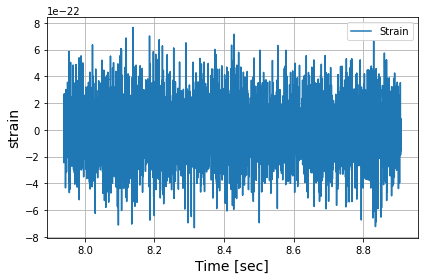

<Figure size 432x288 with 0 Axes>

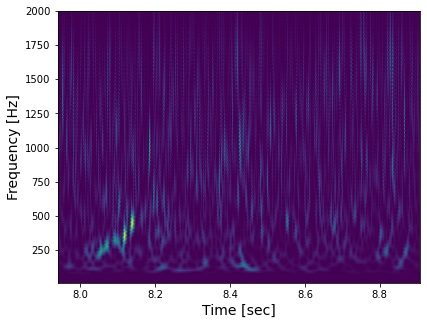

****************************************************************

Window sample No. 1
----------------------
Waveform SNR:  39.522166613566334
Injection location (seconds):  16.008544921875

G-mode slope:  1501.0
Initial frequency, f0 (Hz):  114.87
End frequency, f1 (Hz):  1763.32
Waveform duration (seconds):  0.846923828125

Window initial time (seconds):  15.9384765625
Window end time (seconds):  16.90771484375
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

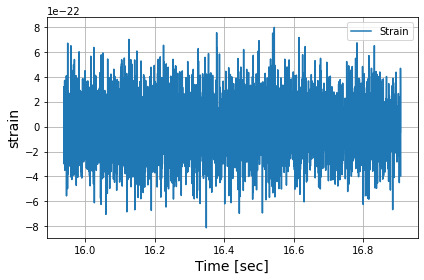

<Figure size 432x288 with 0 Axes>

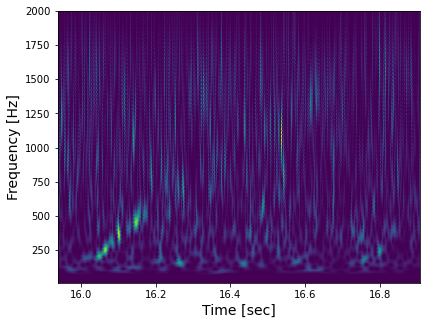

****************************************************************

Window sample No. 2
----------------------
Waveform SNR:  47.393145502740154
Injection location (seconds):  24.007080078125

G-mode slope:  1555.0
Initial frequency, f0 (Hz):  102.41
End frequency, f1 (Hz):  1785.18
Waveform duration (seconds):  0.86767578125

Window initial time (seconds):  23.948974609375
Window end time (seconds):  24.918212890625
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

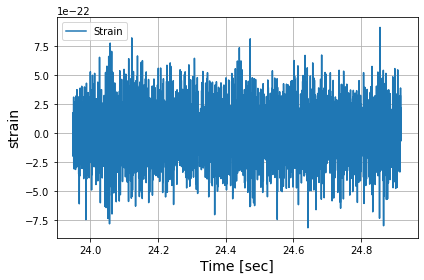

<Figure size 432x288 with 0 Axes>

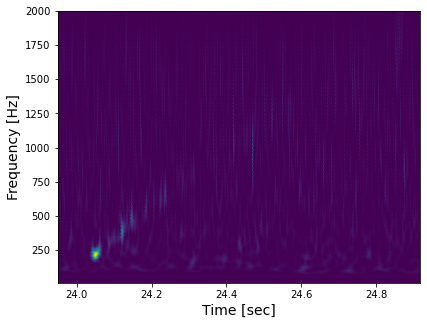

****************************************************************

Window sample No. 3
----------------------
Waveform SNR:  43.42765833425413
Injection location (seconds):  32.005859375

G-mode slope:  1521.0
Initial frequency, f0 (Hz):  115.48
End frequency, f1 (Hz):  1787.69
Waveform duration (seconds):  0.844482421875

Window initial time (seconds):  31.937255859375
Window end time (seconds):  32.906494140625
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

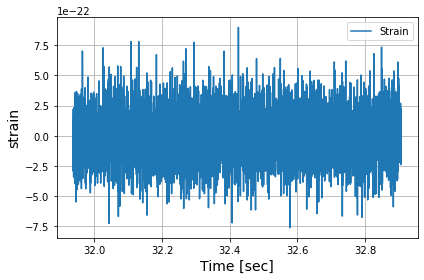

<Figure size 432x288 with 0 Axes>

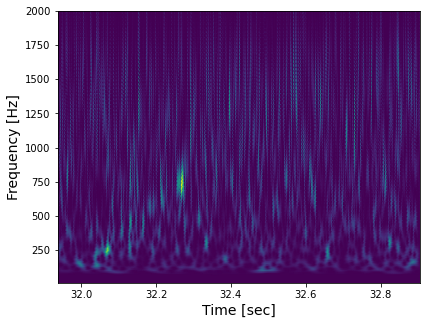

****************************************************************

Window sample No. 4
----------------------
Waveform SNR:  43.2169857618964
Injection location (seconds):  39.9931640625

G-mode slope:  1530.0
Initial frequency, f0 (Hz):  104.22
End frequency, f1 (Hz):  1781.66
Waveform duration (seconds):  0.846435546875

Window initial time (seconds):  39.938232421875
Window end time (seconds):  40.907470703125
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

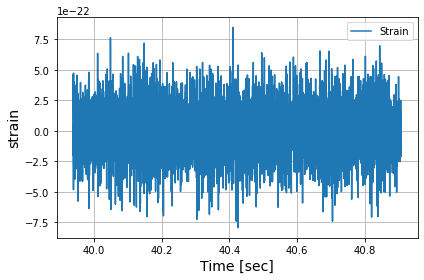

<Figure size 432x288 with 0 Axes>

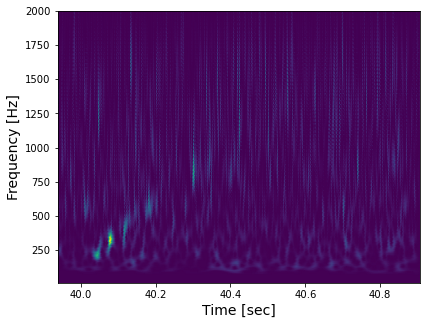

****************************************************************

Window sample No. 5
----------------------
Waveform SNR:  39.04521749132747
Injection location (seconds):  47.995361328125

G-mode slope:  1524.0
Initial frequency, f0 (Hz):  116.18
End frequency, f1 (Hz):  1788.94
Waveform duration (seconds):  0.846923828125

Window initial time (seconds):  47.9384765625
Window end time (seconds):  48.90771484375
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

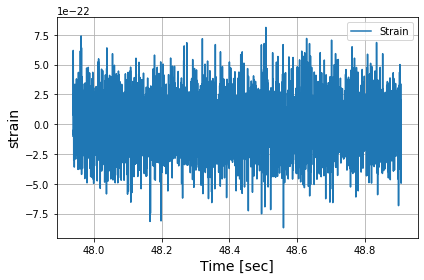

<Figure size 432x288 with 0 Axes>

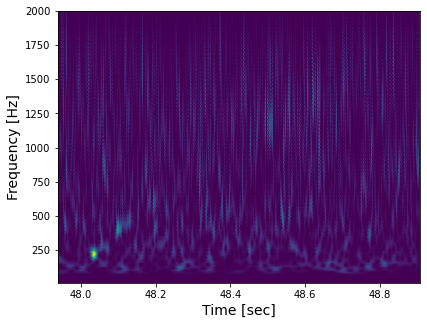

****************************************************************

Window sample No. 6
----------------------
Waveform SNR:  41.97339442034522
Injection location (seconds):  56.001953125

G-mode slope:  1506.0
Initial frequency, f0 (Hz):  110.75
End frequency, f1 (Hz):  1755.78
Waveform duration (seconds):  0.8544921875

Window initial time (seconds):  55.9423828125
Window end time (seconds):  56.91162109375
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

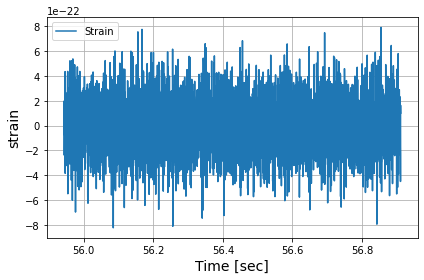

<Figure size 432x288 with 0 Axes>

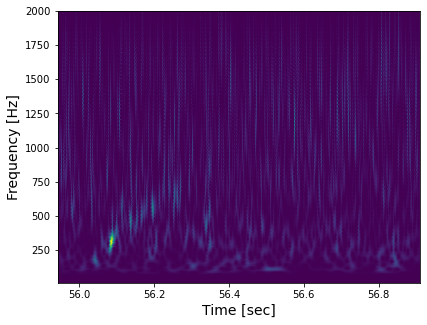

****************************************************************

Window sample No. 7
----------------------
Waveform SNR:  43.05750699263813
Injection location (seconds):  64.000244140625

G-mode slope:  1596.0
Initial frequency, f0 (Hz):  104.02
End frequency, f1 (Hz):  1797.74
Waveform duration (seconds):  0.898193359375

Window initial time (seconds):  63.964111328125
Window end time (seconds):  64.933349609375
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

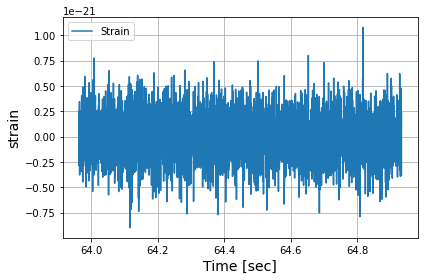

<Figure size 432x288 with 0 Axes>

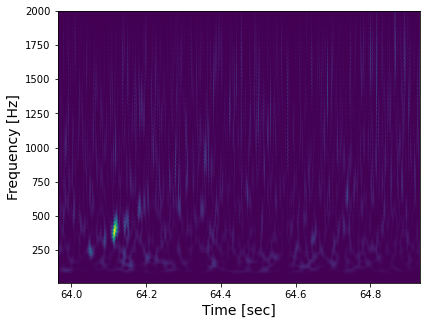

****************************************************************

Window sample No. 8
----------------------
Waveform SNR:  43.60768234041168
Injection location (seconds):  72.009521484375

G-mode slope:  1546.0
Initial frequency, f0 (Hz):  109.15
End frequency, f1 (Hz):  1771.36
Waveform duration (seconds):  0.878662109375

Window initial time (seconds):  71.954345703125
Window end time (seconds):  72.923583984375
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

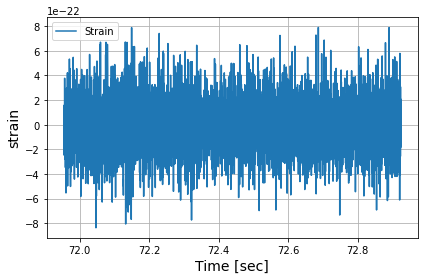

<Figure size 432x288 with 0 Axes>

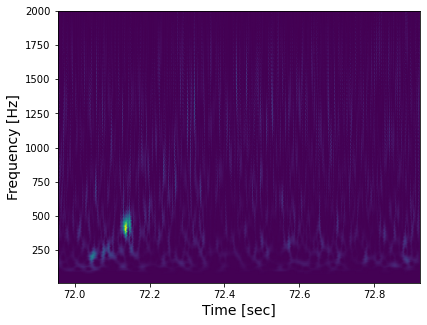

****************************************************************

Window sample No. 9
----------------------
Waveform SNR:  46.00530053598593
Injection location (seconds):  80.00537109375

G-mode slope:  1452.0
Initial frequency, f0 (Hz):  119.2
End frequency, f1 (Hz):  1754.02
Waveform duration (seconds):  0.810791015625

Window initial time (seconds):  79.92041015625
Window end time (seconds):  80.8896484375
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

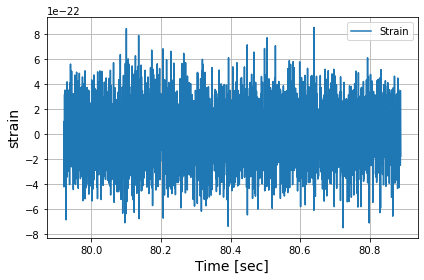

<Figure size 432x288 with 0 Axes>

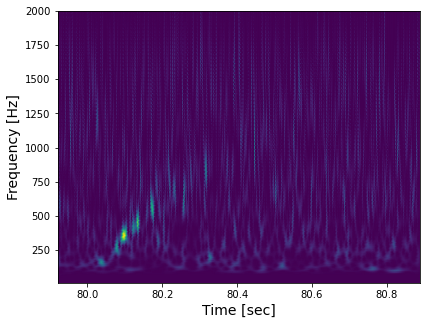

****************************************************************

Window sample No. 10
----------------------
Waveform SNR:  47.719715034845656
Injection location (seconds):  88.004150390625

G-mode slope:  1493.0
Initial frequency, f0 (Hz):  111.26
End frequency, f1 (Hz):  1758.54
Waveform duration (seconds):  0.8388671875

Window initial time (seconds):  87.9345703125
Window end time (seconds):  88.90380859375
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

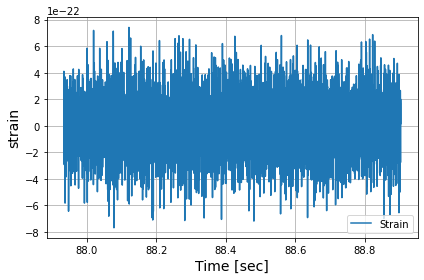

<Figure size 432x288 with 0 Axes>

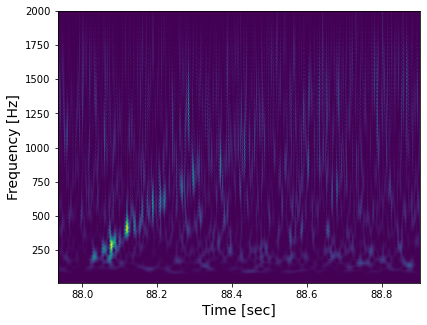

****************************************************************

Window sample No. 11
----------------------
Waveform SNR:  43.606921503211375
Injection location (seconds):  95.994873046875

G-mode slope:  1499.0
Initial frequency, f0 (Hz):  112.06
End frequency, f1 (Hz):  1766.08
Waveform duration (seconds):  0.8388671875

Window initial time (seconds):  95.9345703125
Window end time (seconds):  96.90380859375
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

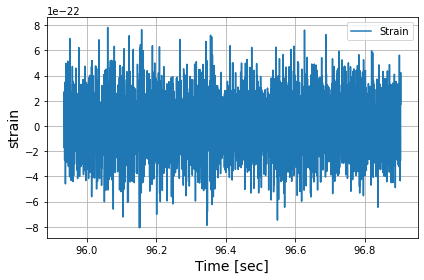

<Figure size 432x288 with 0 Axes>

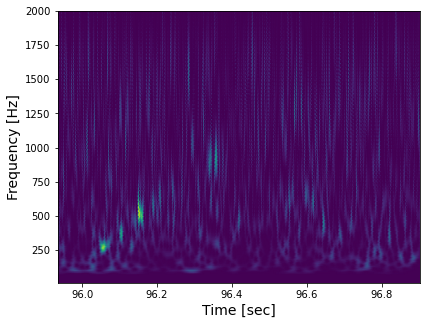

****************************************************************

Window sample No. 12
----------------------
Waveform SNR:  42.559533672643035
Injection location (seconds):  103.998291015625

G-mode slope:  1562.0
Initial frequency, f0 (Hz):  114.77
End frequency, f1 (Hz):  1782.66
Waveform duration (seconds):  0.890625

Window initial time (seconds):  103.96044921875
Window end time (seconds):  104.9296875
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

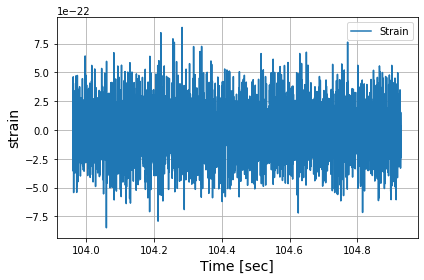

<Figure size 432x288 with 0 Axes>

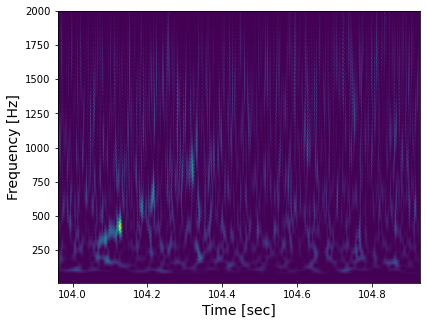

****************************************************************

Window sample No. 13
----------------------
Waveform SNR:  41.589629763661655
Injection location (seconds):  112.004638671875

G-mode slope:  1487.0
Initial frequency, f0 (Hz):  105.53
End frequency, f1 (Hz):  1759.55
Waveform duration (seconds):  0.825439453125

Window initial time (seconds):  111.927734375
Window end time (seconds):  112.89697265625
Extracted  3970  data points



<Figure size 432x288 with 0 Axes>

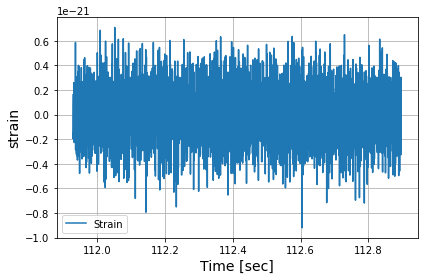

<Figure size 432x288 with 0 Axes>

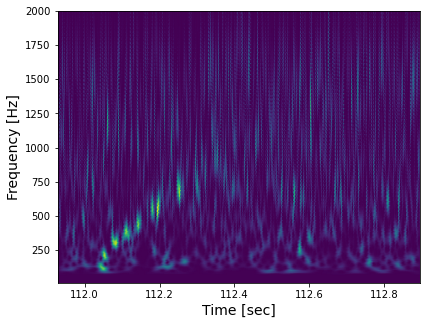

****************************************************************



<Figure size 432x288 with 0 Axes>

In [17]:
doplots_samples = set_doplots # CHECK, plot samples (time domain | TF representation)

# ------> Generate window samples

# Sampling frequency
ts = t[1] - t[0]
fs = 1 / ts

# Window for spectrograms
wnd="hamming"

# Initialize list of windows
all_windows = []

# Initialize list for updated log file
log_data = []

# FIRST LOOP, j index: window count variable
# --------------------------------------------

for j in range(len(t_inj)): # Extract all windows along the strain segment
#for j in range(5): # Extract only a few windows along the strain segment

    print("Window sample No.", j)
    print("----------------------")
    
    window = np.zeros(int(fs*Twin))

    # SECOND LOOP, k index: Window samples count variable
    # --------------------------------------------------------
    
    for k in range(len(window)):
        
        # Extract strain data along the window
        window[k] = s[locate_win[j]+k]
    
    all_windows.append(window)
    
    print("Waveform SNR: ", wf_SNR[j])
    print("Injection location (seconds): ", t_inj[j])
    print("")
    print("G-mode slope: ", Slope[j])
    print("Initial frequency, f0 (Hz): ", f_ini[j])
    print("End frequency, f1 (Hz): ", f_end[j])
    print("Waveform duration (seconds): ", wf_duration[j])
    print("")
    print("Window initial time (seconds): ", t[locate_win[j]])
    print("Window end time (seconds): ", t[locate_win[j]+k])
    #print("Window length (in seconds):", t[locate_win[j]+k]-t[locate_win[j]])
    print("Extracted ", k, " data points")
    
    # CHECK: To ensure injection location is inside window sample
    
    if t_inj[j] < t[locate_win[j]]:
        print("!!!!!!!!!!!!!!!!! ERROR : t_injection is before the sample window")
    
    elif j < len(t_inj)-1:
        if t_inj[j] > t[locate_win[j+1]]:
            print("!!!!!!!!!!!!!!!!! ERROR : t_injection is after the sample window ")
    
    print("")
    
    # Select window samples belonging in a specific SNR range
    # ----------------------------------------------------------
    
    #if wf_SNR[j] >= 18:
        #if wf_SNR[j] <= 24:
    if wf_SNR[j] <= 100:
        
        if doplots_samples:
            
            # Plot the window sample (strain)
            # ---------------------------------
            
            plt.figure(1, figsize=(6,4))
        
            #plt.plot(np.arange(0, Twin, ts), all_windows[num_win], label='Strain')
            plt.plot(t[locate_win[j]:locate_win[j]+len(window)], all_windows[j], label='Strain')
            #plt.title("Sample", fontsize=15)
            plt.xlabel('Time [sec]', fontsize=14)
            plt.ylabel('strain', fontsize=14)
            plt.grid()
            plt.legend()
            plt.tight_layout()
            plt.show()
            plt.figure(1).clear()
            gc.collect()
    
            # Plot the window sample (TF representation)
            # --------------------------------------
    
            #freq, time, Sxx = signal.spectrogram(all_windows[j], fs, window=wnd, nperseg=256)
            time, freq, Sxx = WaveletTF_transform(all_windows[j], fs, 10, 2000, 10, 7, 0)
    
            plt.figure(2, figsize=(6.5,5))
            plt.pcolormesh(time+t[locate_win[j]], freq, Sxx, shading='gouraud')
            plt.ylabel('Frequency [Hz]', fontsize=14)
            plt.xlabel('Time [sec]', fontsize=14)
            plt.show()
        
            plt.figure(2).clear()
            gc.collect()
            
        # Save information in log_data list
        log_data.append([t_inj[j], jitter[j], wf_SNR[j], Slope[j], f_ini[j], f_end[j], wf_duration[j]])
    
        # Save window samples
        sample_number = str(j).zfill(6)
        df_strain = pd.DataFrame({"time (seconds)" : t[locate_win[j]:locate_win[j]+len(window)], "strain" : all_windows[j]})
        df_strain.to_csv(datasets_dir + "/sample_strain_" + sample_number + ".txt", index=False)
 
        print("****************************************************************")
        print("")

## 6. Update and save log data

In [18]:
# ------> Create df_log dataframe
df_log = pd.DataFrame(log_data, columns=['Injection time [s]', 'jitter (seconds)', 'Waveform SNR', 'G-mode slope', 'Frequency f0 [Hz]', 'Frequency f1 [Hz]', 'Waveform duration [s]'])

# ------> Export df_log dataframe to a csv file
df_log.to_csv(datasets_dir + '/log.dat', index=False)